Not a lot that I could say on the matter that wasn't fantastically-handled by [this blog series](https://benalexkeen.com/linear-programming-with-python-and-pulp/).

Instead, I'll follow along the posts, distilling key principles and elaborating where needed.

### [Part 1](https://benalexkeen.com/linear-programming-with-python-and-pulp-part-1/)

In a valid system of linear constraints, there's some region of feasible solutions, as the author represents in gray.

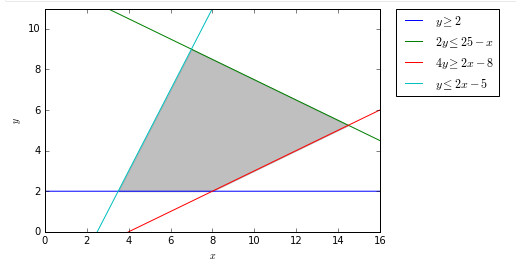

In [1]:
from IPython.display import Image
Image('images/simple_linear_case.PNG')

Then, as they show by inspection, the maxima of linear programming problems lies at the corners of these areas.

Of course, the reason that this whole problem space exists is because the notion of "corners" is trivial in 2D, but quickly gets unwieldy in higher dimensions

### [Part 2](https://benalexkeen.com/linear-programming-with-python-and-pulp-part-2/)

The basic anatomy of using `pulp` is

1. Instantiate your problem with the objective being either `LpMinimize` or `LpMaximize`
2. Build out your variables using `LpVariable`. In the simple case, you can optionally constrain upper and lower bounds, as well as determine whether your variable is `Continuous`, `Integer`, or `Binary`
3. Use the `+=` operator on your `LpProblem` object to define the equation you aim your optimization objective at
4. Use the `+=` operator on your `LpProblem` object to add any constraints
5. Use the `.solve()` method on your `LpProblem` to solve, which **modifies all of your variables in place**
6. Print your solutions using a blend of `.varVal` and `pulp.value`

One thing that confused the hell out of me is how overloaded the `+=` operator is. Let's pull back the curtain a bit.

Using the same example as the author:

In [3]:
from pulp import LpProblem, LpVariable

prob = LpProblem('prob')
x = LpVariable('x', lowBound=0)
y = LpVariable('y', lowBound=0)

Let's look at some of the right sides of equations in `ln [4]`

In [4]:
4 * x + 3 * y

4*x + 3*y + 0

In [5]:
2 * y <= 25

2*y + -25 <= 0

These *look* the same, as far as their `__repr__` go, but looking at the type, we see

In [6]:
type(4 * x + 3 * y)

pulp.pulp.LpAffineExpression

In [7]:
type(2 * y <= 25)

pulp.pulp.LpConstraint

Peeking under the hood, there's some really clever API design at play here. `x` is of class `LpVariable`

In [8]:
type(x)

pulp.pulp.LpVariable

Which inherits from type `LpElement`

In [9]:
type(x).__bases__

(pulp.pulp.LpElement,)

Which is loaded to the brim with dunder methods that use any arithmetic to return `LpAffineExpression` objects

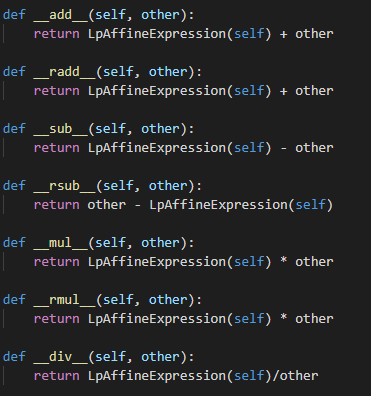

In [10]:
Image('images/affine_expr.PNG')

So in that second example,

In [11]:
2 * y <= 25

2*y + -25 <= 0

The left side uses the `__mul__` and becomes an `LpAffineExpression`

In [12]:
type(2 * y)

pulp.pulp.LpAffineExpression

Then *that* object uses the `__le__` method which returns an `LpConstraint` object

In [13]:
type(2 * y <= 25)

pulp.pulp.LpConstraint

It's worth noting that because of [the Python operator precedence](https://data-flair.training/blogs/python-operator-precedence/), the `<=, >=, ==` operators happen pretty close to last, and thus we can also write that same expression backwards

In [14]:
type(25 >= y * 2)

pulp.pulp.LpConstraint

Putting it all together, we'll inspect the `+=` dunder method for our `LpProblem` variable, `prob`.

As you can see (and as the author illustrates), calling `+=` has different behavior depending on whether you're using `LpConstraint` or `LpAffineExpression`.

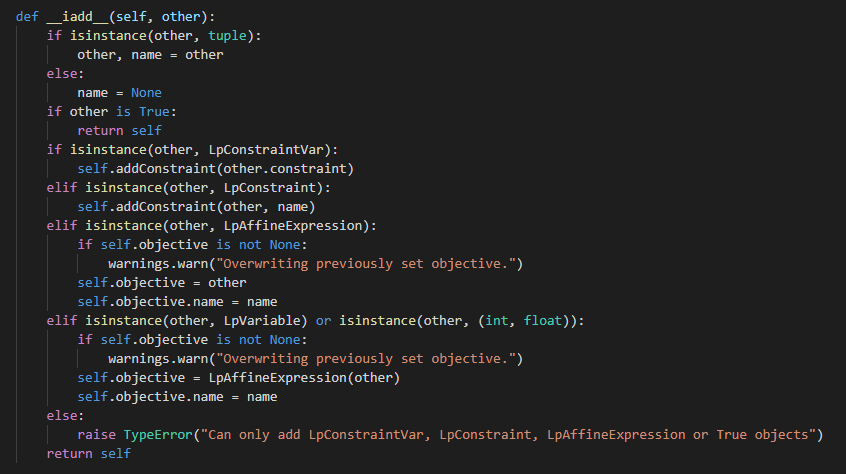

In [15]:
Image('images/iadd.PNG')

Not terribly transparent, but it's good design, once you know how it all fits together!

### [Part 3](https://benalexkeen.com/linear-programming-with-python-and-pulp-part-3/)

This post is pretty straight-forward. Does a good job highlighting how calling the `.solve()` method updates everying in place, and retrieval via `pulp.value` and `.varValue`.

### [Part 4](https://benalexkeen.com/linear-programming-with-python-and-pulp-part-4/)

This post highlights the finesse of structuring your Linear Programming problem, as well as introducing two other topics of note: `LpVariable.dicts` and `lpSum`

#### `.dicts()`

As you might expect, the literal construction of your problem can get unwieldy as you get more and more constraints. This is essentially a clever utility that lets you programmatically create `LpVariable` objects.

First, let's look at the instantiation call. This is almost identical to our typical `LpVariable` call, including `name`, the `bound`s, and data type in `cat`. However, the key difference here is in the `indexs` argument. This works in concert with `name` to loop through your `indexs` iterable and generate unique variable names of the form `name_index`, as you can see below.

In [16]:
indexes = ['a', 'b', 'c']
test = LpVariable.dicts(name='test', indexs=indexes,
                        lowBound=0, cat='Continuous')

test

{'a': test_a, 'b': test_b, 'c': test_c}

It's worth noting that this operation returns a simple, vanilla dictionary

In [17]:
type(test)

dict

Whose contents are all of type `LpVariable`

In [18]:
type(test['a'])

pulp.pulp.LpVariable

and have been instantiated with the arguments found in the top-level call

In [19]:
test['a'].lowBound, test['a'].cat

(0, 'Continuous')

And so in the example post, the author essentially does some list comprehension magic to make all `n x m` variables that are unique combinations of the `sausage_types` and `ingredients`.

Because this is a tuple of strings, it's hashable, and becomes the key to the dictionary

In [20]:
import pulp

# Construct our decision variable lists
sausage_types = ['economy', 'premium']
ingredients = ['pork', 'wheat', 'starch']

ing_weight = pulp.LpVariable.dicts("weight kg",
                                     ((i, j) for i in sausage_types for j in ingredients),
                                     lowBound=0,
                                     cat='Continuous')

ing_weight

{('economy', 'pork'): weight_kg_('economy',_'pork'),
 ('economy', 'wheat'): weight_kg_('economy',_'wheat'),
 ('economy', 'starch'): weight_kg_('economy',_'starch'),
 ('premium', 'pork'): weight_kg_('premium',_'pork'),
 ('premium', 'wheat'): weight_kg_('premium',_'wheat'),
 ('premium', 'starch'): weight_kg_('premium',_'starch')}

Behind the scenes, `pulp` string-ifies the combination of `name` and, as above, creates the variables with the correct arguments.

In [21]:
ing_weight['economy', 'pork']

weight_kg_('economy',_'pork')

#### .lpSum()

This one wasn't immediately obvious to me. Essentially, `.lpSum()` provides a similar means for programmatic criteria generation. To see why this is necessary, in our overall problem we're trying to minimize cost, across 6 variables. But because there are 3 unique costs, there's obviously a more elegant way to express the final cost than just writing all 6 of them out.

In [22]:
from pulp import lpSum

In [23]:
from warnings import filterwarnings
filterwarnings('ignore')

model = pulp.LpProblem("Cost minimising blending problem", pulp.LpMinimize)

So we do a simple list comprehension to express that, which gives us a tuple of 2 `LpAffineExpressions`

In [24]:
costs = [4.32 * ing_weight[(i, 'pork')]
         + 2.46 * ing_weight[(i, 'wheat')]
         + 1.86 * ing_weight[(i, 'starch')]
         for i in sausage_types]
costs

[4.32*weight_kg_('economy',_'pork') + 1.86*weight_kg_('economy',_'starch') + 2.46*weight_kg_('economy',_'wheat') + 0.0,
 4.32*weight_kg_('premium',_'pork') + 1.86*weight_kg_('premium',_'starch') + 2.46*weight_kg_('premium',_'wheat') + 0.0]

In [25]:
type(costs[0])

pulp.pulp.LpAffineExpression

Should be able to pipe that in, yeah?

In [26]:
model += (costs)

TypeError: Can only add LpConstraintVar, LpConstraint, LpAffineExpression or True objects

Nope. Instead, we'll use `lpSum()`. I think what threw me for a loop was that this isn't necessarily a *sum*-- after all, aren't there a number of multiplication terms?

Perhaps a more accurate name for this function would be `LpAffineExpression.from_iter()`, because it's essentially there to allow you to assemble an `LpAffineExpression` object from an iterable of them, but alas, knowing what the `lpSum` function does, we can just think of as "a sum of affine expressions."

In [27]:
model += (
    pulp.lpSum([
        4.32 * ing_weight[(i, 'pork')]
        + 2.46 * ing_weight[(i, 'wheat')]
        + 1.86 * ing_weight[(i, 'starch')]
        for i in sausage_types])
)

model

Cost_minimising_blending_problem:
MINIMIZE
4.32*weight_kg_('economy',_'pork') + 1.86*weight_kg_('economy',_'starch') + 2.46*weight_kg_('economy',_'wheat') + 4.32*weight_kg_('premium',_'pork') + 1.86*weight_kg_('premium',_'starch') + 2.46*weight_kg_('premium',_'wheat') + 0.0
VARIABLES
weight_kg_('economy',_'pork') Continuous
weight_kg_('economy',_'starch') Continuous
weight_kg_('economy',_'wheat') Continuous
weight_kg_('premium',_'pork') Continuous
weight_kg_('premium',_'starch') Continuous
weight_kg_('premium',_'wheat') Continuous

Finally, we can see that the author uses this same function to generate multiple *constraints* as well

In [28]:
model += pulp.lpSum([ing_weight['economy', j] for j in ingredients]) == 350 * 0.05
model += pulp.lpSum([ing_weight['premium', j] for j in ingredients]) == 500 * 0.05

model

Cost_minimising_blending_problem:
MINIMIZE
4.32*weight_kg_('economy',_'pork') + 1.86*weight_kg_('economy',_'starch') + 2.46*weight_kg_('economy',_'wheat') + 4.32*weight_kg_('premium',_'pork') + 1.86*weight_kg_('premium',_'starch') + 2.46*weight_kg_('premium',_'wheat') + 0.0
SUBJECT TO
_C1: weight_kg_('economy',_'pork') + weight_kg_('economy',_'starch')
 + weight_kg_('economy',_'wheat') = 17.5

_C2: weight_kg_('premium',_'pork') + weight_kg_('premium',_'starch')
 + weight_kg_('premium',_'wheat') = 25

VARIABLES
weight_kg_('economy',_'pork') Continuous
weight_kg_('economy',_'starch') Continuous
weight_kg_('economy',_'wheat') Continuous
weight_kg_('premium',_'pork') Continuous
weight_kg_('premium',_'starch') Continuous
weight_kg_('premium',_'wheat') Continuous

### [Part 5](https://benalexkeen.com/linear-programming-with-python-and-pulp-part-5/)

Finally, this post-- and the one after it-- bring it all together, showing how to interface between `pulp` and a more-traditional `pandas` workflow.

I want to put particular emphasis on how well-designed keys for `LpVariable.dicts` allows the author to simultaneously interface with the `pandas.DataFrame` that houses our optimization criteria, as well as the `pulp` objects that he's constructing. For instance, the overall problem statement is "minimize all costs", which is achieved through their simple model instantiation (`model = LpProblem('Cost minimize', pulp.LpMinimize)`) and this monster of a `pulp.lpSum`

```
model += pulp.lpSum(
    [production[month, factory] * factories.loc[(month, factory), 'Variable_Costs']
       for month, factory in factories.index]
       
    + [factory_status[month, factory] * factories.loc[(month, factory), 'Fixed_Costs']
       for month, factory in factories.index]
)
```

This is actually pretty straight-forward to read when you deconstruct.

`production[month, factory]` and `factory_status[month, factory]` are two dicts of `LpVariables` and `factories.loc[(month, factory), ...]` just reference the relevant cells within the `DataFrame` to complete the equation.

Finally, the author goes through and tailors the constraints for each month/factory combination by going through and *updating the records of the dictionary*.

```
for month, factory in factories.index:
    min_production = factories.loc[(month, factory), 'Min_Capacity']
    max_production = factories.loc[(month, factory), 'Max_Capacity']
    model += production[(month, factory)] >= min_production * factory_status[month, factory]
    model += production[(month, factory)] <= max_production * factory_status[month, factory]
```

Building these dictionaries form `LpVariable.dicts` was handy for their organization and default behavior, but this step allows us to update, instead of building a whole mess of `lpVariables` from scratch, instantiating with the appropriate values of `lowBound` and `upBound`.

Aaaaand for good measure, creating the super-specific constraints in the problem statement are two simple dictionary calls

```
# Factory B is off in May
model += factory_status[5, 'B'] == 0
model += production[5, 'B'] == 0
```

[The last post in his series is super interesting](http://www.benalexkeen.com/linear-programming-with-python-and-pulp-part-6), but in my estimation, not so fundamental that I'll elaborate in this notebook.